# Convolutional Neural Networks 

So far, we have used feed-forward neural networks with fully connected layers.
While fully connected layers are useful, they are not always what we want.

Specifically, fully connected layers require a lot of connections. Suppose
we are trying to determine whether an image of size $200 \times 200$ contains
a cat. Our input layer would need to have $200 \times 200 = 40000$ units,
one for each pixel.
A fully connected layer between the input and the first hidden layer with, say,
 500 hidden units will require a whopping $40000 \times 500 =$ 20 million connections!

The large number of connections means several things. For one, computing
predictions will require a lot of processing time. For another, we will
have a large number of *weights*, making our network very high capacity.
The high capacity of the network means that we will need a large number of training
examples to avoid overfitting.

There is also one other issue. What happens if our image is shifted a little,
say one pixel to the left? Even though the change is minor from our point of view,
the intensity at each pixel location could change drastically. We can
get a completely different prediction from our network.

Since there are many well-written resources on convolutional neural networks,
these notes will be terser than usual.

## Locally Connected Layers

What we will do is look for **local** features. For example, features like
edges, textures, and other patterns depend only on pixel intensities in a small
region.  Here is an example of a **locally connected layer**:

<img src="imgs/local.png" width="400px">

Each unit in the (first) hidden layer detects patterns in a small portion of the input
image. This way, we have fewer connections (and therefore weights) between
the input and the first hidden layer.

There is biological evidence that the (biological) neural connectivity in the visual
cortex works the same way, where neurons detect features that occur in a small region
of our receptive field. Neurons close to the retina detect simple patterns like
edges. Neurons that receive information from these simple cells detect more complicated
patterns. Neurons in even higher layers detect even more complicated patterns.

<img src="imgs/biology.png" width="400px">

## Weight Sharing

If we know how to detect a local feature in one region of the image -- say, an edge in a certain orientation --
then we know how to detect that feature in other regions of the image.
This is the idea behind **weight sharing**: we will share the **same parameters** across different **locations**
in an image.

<img src="imgs/sharing.png" width="400px">

<img src="imgs/conv.png" width="200px">

## Filters in Computer Vision

People have used the idea of convolutional filters in computer vision even before
the rise of machine learning. They hand-coded filters that can detect simple features,
for example edges in various orientations:

<img src="imgs/sobel1.png" width="400px">
<img src="imgs/sobel2.png" width="400px">

## The Convolutional Layer

Recall that in PyTorch, we can create a fully-connected layer
between successive layers like this:

In [3]:
import torch.nn as nn

# fully-connected layer between a lower layer of size 100, and 
# a higher layer of size 30
fc = nn.Linear(100, 30)

We've applied a layer like this as follows:

In [4]:
import torch
x = torch.randn(100) # create a tensor of shape [100]
y = fc(x)            # apply the fully conected layer `fc` to x
y.shape

torch.Size([30])

In PyTorch, we can create a convolutional layer using `nn.Conv2d`:

In [5]:
conv = nn.Conv2d(in_channels=3,  # number of channels in the input (lower layer)
                 out_channels=7, # number of channels in the output (next layer)
                 kernel_size=5)  # size of the kernel or receiptive field

The `conv` layer expects as input a tensor in the format "NCHW", meaning that
the dimensions of the tensor should follow the order:

* batch size
* channel
* height
* width

For example, we can emulate a batch of 32 colour images, each of size 128x128, like this:

In [6]:
x = torch.randn(32, 3, 128, 128)
y = conv(x)
y.shape

torch.Size([32, 7, 124, 124])

The output tensor is also in the "NCHW" format. We still have 32 images, and 7 channels
(consistent with `out_channels` of `conv`), and of size 124x124. If we added the appropriate
padding to `conv`, namely `padding = kernel_size // 2`, then our output width and height should
be consistent with the input width and height:

In [7]:
conv2 = nn.Conv2d(in_channels=3,
                  out_channels=7,
                  kernel_size=5,
                  padding=2)

x = torch.randn(32, 3, 128, 128)
y = conv2(x)
y.shape

torch.Size([32, 7, 128, 128])

To further illustrate the formatting, let's apply the (random, untrained) convolution `conv2` to
a real image. First, we load the image:

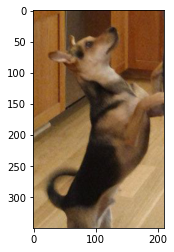

In [8]:
import matplotlib.pyplot as plt
import numpy as np

img = plt.imread("imgs/dog_mochi.png")[:, :, :3]
plt.imshow(img)

Then, we convert the image into a PyTorch tensor of the appropriate shape.

In [10]:
x = torch.from_numpy(img) # turn img into a PyTorch tensor
print(x.shape)
x = x.permute(2,0,1)      # move the channel dimension to the beginning
print(x.shape)
x = x.reshape([1, 3, 350, 210]) # add a dimension for batching
print(x.shape)

torch.Size([350, 210, 3])
torch.Size([3, 350, 210])
torch.Size([1, 3, 350, 210])


Even when our batch size is 1, we still need the first dimension so that the input
follows the "NCHW" format.

In [11]:
y = conv2(x)           # apply the convolution
y = y.detach().numpy() # convert the result into numpy
y = y[0]               # remove the dimension for batching

# normalize the result to [0, 1] for plotting
y_max = np.max(y)
y_min = np.min(y)
img_after_conv = y - y_min / (y_max - y_min)
img_after_conv.shape

(7, 350, 210)

Let's plot the 7 channels one by one:

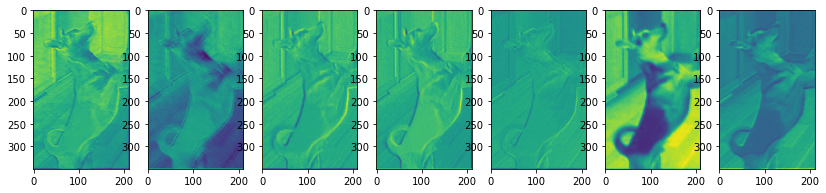

In [12]:
plt.figure(figsize=(14,4))
for i in range(7):
    plt.subplot(1, 7, i+1)
    plt.imshow(img_after_conv[i])

If we were to run a neural network, these would be the unit outputs (prior to applying the activation function).

## Pooling Layers

In [13]:
pool = nn.MaxPool2d(2, 2)
y = conv2(x)
z = pool(y)
z.shape

torch.Size([1, 7, 175, 105])

## Convolutional Networks in PyTorch

In assignment 2, we created the following network. We can understand this network now!

In [14]:
class LargeNet(nn.Module):
    def __init__(self):
        super(LargeNet, self).__init__()
        self.name = "large"
        self.conv1 = nn.Conv2d(3, 5, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(5, 10, 5)
        self.fc1 = nn.Linear(10 * 5 * 5, 32)
        self.fc2 = nn.Linear(32, 1)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 10 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        x = x.squeeze(1) # Flatten to [batch_size]
        return x

This network has **two** convolutional layers: `conv1` and `conv2`.

- The first convolutional layer `conv1` requires an input with 3 channels,
  outputs 5 channels, and has a kernel size of `5x5`. We are not adding any zero-padding.
- The second convolutional layer `conv1` requires an input with 5 channels,
  outputs 10 channels, and has a kernel size of (again) `5x5`. We are not adding any zero-padding.

In the `forward` function we see that the convolution operations are always 
followed by the usual ReLU activation function, and a pooling operation.
The pooling operation used is max pooling, so each pooling operation
reduces the width and height of the neurons in the layer by half.

Because we are not adding any zero padding, we end up with `10 * 5 * 5` hidden units
after the second convolutional layer. These units are then passed to two fully-connected
layers, with the usual ReLU activation in between.

Notice that the number of channels **grew** in later convolutional layers! However,
the number of hidden units in each layer is still reduced because of the pooling operation:

* Initial Image Size: $3 \times 32 \times 32 = 3072$
* After `conv1`: $5 \times 28 \times 28$
* After Pooling: $5 \times 14 \times 14 = 980$
* After `conv2`: $10 \times 10 \times 10$
* After Pooling: $10 \times 5 \times 5 = 250$
* After `fc1`: $32$
* After `fc2`: $1$

This pattern of **doubling the number of channels with every pooling / strided convolution**
is common in convolutional architectures. It is used to avoid loss of too much information within
a single convolution.

## AlexNet in PyTorch

Convolutional networks are very commonly used, meaning that there are often alternatives to
training convolutional networks from scratch. In particular, researchers often release both
the architecture and **the weights** of the networks they train.

As an example, let's look at the AlexNet model, whose trained weights are included in `torchvision`.
AlexNet was trained to classify images into one of many categories.
The AlexNet can be imported like below.

In [15]:
import torchvision.models

alexNet = torchvision.models.alexnet(pretrained=True)
alexNet

Downloading: "https://download.pytorch.org/models/alexnet-owt-4df8aa71.pth" to /home/yichuan/.cache/torch/hub/checkpoints/alexnet-owt-4df8aa71.pth


AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

Notice that the AlexNet model is split into two parts. There is a component that computes
"features" using convolutions.

In [16]:
alexNet.features

Sequential(
  (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
  (1): ReLU(inplace=True)
  (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (4): ReLU(inplace=True)
  (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (7): ReLU(inplace=True)
  (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (9): ReLU(inplace=True)
  (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
)

There is also a component that classifies the image based on the computed features.

In [17]:
alexNet.classifier

Sequential(
  (0): Dropout(p=0.5, inplace=False)
  (1): Linear(in_features=9216, out_features=4096, bias=True)
  (2): ReLU(inplace=True)
  (3): Dropout(p=0.5, inplace=False)
  (4): Linear(in_features=4096, out_features=4096, bias=True)
  (5): ReLU(inplace=True)
  (6): Linear(in_features=4096, out_features=1000, bias=True)
)

### AlexNet Features

The first network can be used independently of the second. Specifically, it can be used
to compute a set of **features** that can be used later on. This idea of using neural
network activation *features* to represent images is an extremely important one, so it
is important to understand the idea now.

If we take our image `x` from earlier and apply it to the `alexNet.features` network,
we get some numbers like this:

In [18]:
features = alexNet.features(x)
features.shape

torch.Size([1, 256, 9, 5])

The set of numbers in `features` is another way of representing our image `x`. Recall that
our initial image `x` was also represented as a tensor, also a set of numbers representing
pixel intensity. Geometrically speaking, we are using points in a high-dimensional space to
represent the images. In our pixel representation, the axes in this high-dimensional space
were different pixels. In our `features` representation, the axes are not as easily
interpretable.

But we will want to work with the `features` representation, because this representation
makes classification easier. This representation organizes images in a more "useful" and
"semantic" way than pixels.

Let me be more specific:
this set of `features` was trained on image classification. It turns out that
**these features can be useful for performing other image-related tasks as well!**
That is, if we want to perform an image classification task of our own (for example,
classifying cancer biopsies, which is nothing like what AlexNet was trained to do),
we might compute these AlexNet features, and then train a small model on top of those
features. We replace the `classifier` portion of `AlexNet`, but keep its `features`
portion intact.

Somehow, through being trained on one type of image classification problem, AlexNet 
learned something general about representing images.


### AlexNet First Convolutions

Since we have a trained model, we might as well visualize outputs of a trained convolution,
to contrast with the untrained convolution we visualized earlier.

Here is the first convolution of AlexNet, applied to our image of Mochi.

In [19]:
alexNetConv = alexNet.features[0]
y = alexNetConv(x)

The output is a $1 \times 64 \times 86 \times 51$ tensor.

In [20]:
y = y.detach().numpy()
y = (y - y.min()) / (y.max() - y.min())
y.shape

(1, 64, 86, 51)

We can visualize each channel independently.

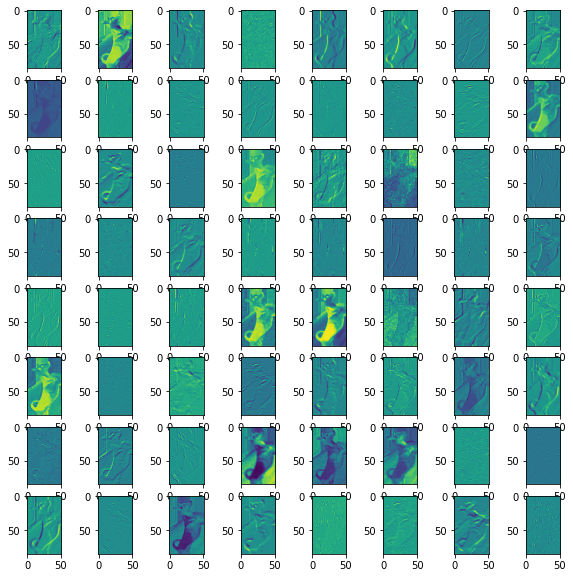

In [21]:
plt.figure(figsize=(10,10))
for i in range(64):
    plt.subplot(8, 8, i+1)
    plt.imshow(y[0, i])